In [1]:
import ast
import json
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
import warnings
from tqdm import tqdm
import datetime
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from sklearn import preprocessing
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import lightgbm as lgb
from functools import partial
import copy
import time
import seaborn as sns
import scipy as sp
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows",100)
np.set_printoptions(precision=8)
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
my_pal = sns.color_palette(n_colors=10)

In [2]:
# Read in the data CSV files
train = pd.read_csv('../input/data-science-bowl-2019/train.csv')
train_labels = pd.read_csv('../input/data-science-bowl-2019/train_labels.csv')
test = pd.read_csv('../input/data-science-bowl-2019/test.csv')

In [3]:
ss = pd.read_csv('../input/data-science-bowl-2019/sample_submission.csv')

In [4]:
keep_id = train[train.type == "Assessment"][['installation_id']].drop_duplicates()
train = pd.merge(train, keep_id, on="installation_id", how="inner")
train = train[train.installation_id.isin(train_labels.installation_id.unique())]
train.shape

(7734558, 11)

In [5]:
print("train.csv shape: ", train.shape)
print("train_labels.csv shape: ", train_labels.shape)
print("test.csv shape: ", test.shape)

train.csv shape:  (7734558, 11)
train_labels.csv shape:  (17690, 7)
test.csv shape:  (1156414, 11)


In [6]:
train['timestamp'] = pd.to_datetime(train['timestamp'])
train['date'] = train['timestamp'].dt.date
train['hour'] = train['timestamp'].dt.hour
train['weekday_name'] = train['timestamp'].dt.weekday_name

test['timestamp'] = pd.to_datetime(test['timestamp'])
test['date'] = test['timestamp'].dt.date
test['hour'] = test['timestamp'].dt.hour
test['weekday_name'] = test['timestamp'].dt.weekday_name

# title of games/videos when the type is assessment
it always includes (Assessment) in the title

In [7]:
train[train.type=="Assessment"]["title"].value_counts()

Mushroom Sorter (Assessment)    192906
Bird Measurer (Assessment)      188466
Chest Sorter (Assessment)       186421
Cauldron Filler (Assessment)    177669
Cart Balancer (Assessment)      158143
Name: title, dtype: int64

In [8]:
train_labels.head(10)

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3
5,197a373a77101924,0006c192,Cauldron Filler (Assessment),1,0,1.0,3
6,957406a905d59afd,0006c192,Bird Measurer (Assessment),1,1,0.5,2
7,b2297d292892745a,0006c192,Mushroom Sorter (Assessment),0,4,0.0,0
8,ae691ec5ad5652cf,00129856,Bird Measurer (Assessment),1,0,1.0,3
9,7b536271e99518f0,001d0ed0,Bird Measurer (Assessment),0,5,0.0,0


# finding match between train and train_labels by one id

In [9]:
summarized_df = train_labels[train_labels.installation_id == "0006a69f"]
#summarized_df.to_csv("summarized_result.csv", index=False)
summarized_df

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


From Kaggle: The file train_labels.csv has been provided to show how these groups would be computed on the assessments in the training set. Assessment attempts are captured in event_code 4100 for all assessments except for Bird Measurer, which uses event_code 4110. If the attempt was correct, it contains "correct":true.

However, in the first version I already noticed that I had one attempt too many for this installation_id when mapping the rows with the train_labels for. It turns out that there are in fact also assessment attemps for Bird Measurer with event_code 4100, which should not count (see below). In this case that also makes sense as this installation_id already had a pass on the first attempt

In [10]:
#train[(train.installation_id == "0006a69f") & ((train.type == "Assessment") & (train.title == 'Bird Measurer (Assessment)') & (train.event_code == 4110) |
#                                               (train.type == "Assessment") & (train.title == 'Bird Measurer (Assessment)') & (train.event_code == 4100))]

In [11]:
train[(train.installation_id == "0006a69f") & ((train.type == "Assessment") & (train.title == 'Bird Measurer (Assessment)') & (train.event_code == 4110) |
                                               (train.type == "Assessment") & (train.title == 'Bird Measurer (Assessment)') & (train.event_code == 4100))].shape[0]

13

When we exclude the Bird Measurer/4100 rows we get the correct match with the numbers in train_labels for this installation_id (1 correct, 11 incorrect)

In [12]:
#train[(train.installation_id == "0006a69f") & (train.type == "Assessment") & (train.title == 'Bird Measurer (Assessment)') & (train.event_code == 4110)]

In [13]:
train[(train.installation_id == "0006a69f") & (train.type == "Assessment") & (train.title == 'Bird Measurer (Assessment)') & (train.event_code == 4110)].shape[0]

12

in terms of Mushroom Sorter (Assessment), there's no Mushromm Sorter/4110 row.

In [14]:
#train[(train.installation_id == "0006a69f") &  (train.type == "Assessment") & (train.title == 'Mushroom Sorter (Assessment)') & (train.event_code == 4100)]

In [15]:
assessment_df = train[(train.installation_id == "0006a69f") & ((train.type == "Assessment") & (train.title == 'Bird Measurer (Assessment)') & (train.event_code == 4110) |
                                               (train.type == "Assessment") & (train.title != 'Bird Measurer (Assessment)') & (train.event_code == 4100))]
assessment_df

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,hour,weekday_name
690,25fa8af4,901acc108f55a5a1,2019-08-06 05:22:32.357000+00:00,"{""correct"":true,""stumps"":[1,2,4],""event_count""...",0006a69f,44,4100,31011,Mushroom Sorter (Assessment),Assessment,TREETOPCITY,2019-08-06,5,Tuesday
1171,17113b36,77b8ee947eb84b4e,2019-08-06 05:35:54.898000+00:00,"{""correct"":false,""caterpillars"":[11,8,3],""even...",0006a69f,29,4110,35771,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,5,Tuesday
1177,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:01.927000+00:00,"{""correct"":false,""caterpillars"":[11,8,11],""eve...",0006a69f,35,4110,42805,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,5,Tuesday
1182,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:06.512000+00:00,"{""correct"":false,""caterpillars"":[11,8,5],""even...",0006a69f,40,4110,47388,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,5,Tuesday
1187,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:09.739000+00:00,"{""correct"":false,""caterpillars"":[11,8,7],""even...",0006a69f,45,4110,50605,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,5,Tuesday
1192,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:13.951000+00:00,"{""correct"":false,""caterpillars"":[11,8,4],""even...",0006a69f,50,4110,54822,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,5,Tuesday
1195,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:17.407000+00:00,"{""correct"":false,""caterpillars"":[11,8,4],""even...",0006a69f,53,4110,58280,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,5,Tuesday
1200,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:21.390000+00:00,"{""correct"":false,""caterpillars"":[11,8,2],""even...",0006a69f,58,4110,62256,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,5,Tuesday
1205,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:26.296000+00:00,"{""correct"":false,""caterpillars"":[11,8,1],""even...",0006a69f,63,4110,67164,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,5,Tuesday
1212,17113b36,77b8ee947eb84b4e,2019-08-06 05:36:32.187000+00:00,"{""correct"":false,""caterpillars"":[11,8,1],""even...",0006a69f,70,4110,73056,Bird Measurer (Assessment),Assessment,TREETOPCITY,2019-08-06,5,Tuesday


In [16]:
all_data = train[train.installation_id == "0006a69f"]
all_data

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,hour,weekday_name
0,27253bdc,34ba1a28d02ba8ba,2019-08-06 04:57:18.904000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,2019-08-06,4,Tuesday
1,27253bdc,4b57c9a59474a1b9,2019-08-06 04:57:45.301000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,2019-08-06,4,Tuesday
2,77261ab5,2b9d5af79bcdb79f,2019-08-06 04:58:14.538000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,4,Tuesday
3,b2dba42b,2b9d5af79bcdb79f,2019-08-06 04:58:14.615000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,4,Tuesday
4,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:16.680000+00:00,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,Sandcastle Builder (Activity),Activity,MAGMAPEAK,2019-08-06,4,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3796,832735e1,0721802df0531701,2019-08-29 16:33:53.227000+00:00,"{""description"":""Let's warm up. Tap a dinosaur ...",0006a69f,11,3010,23145,Dino Dive,Game,MAGMAPEAK,2019-08-29,16,Thursday
3797,ab3136ba,0721802df0531701,2019-08-29 16:33:56.880000+00:00,"{""description"":""Let's warm up. Tap a dinosaur ...",0006a69f,12,3110,26804,Dino Dive,Game,MAGMAPEAK,2019-08-29,16,Thursday
3798,832735e1,0721802df0531701,2019-08-29 16:34:11.881000+00:00,"{""description"":""Let's warm up. Tap a dinosaur ...",0006a69f,13,3010,41805,Dino Dive,Game,MAGMAPEAK,2019-08-29,16,Thursday
3799,ab3136ba,0721802df0531701,2019-08-29 16:34:15.480000+00:00,"{""description"":""Let's warm up. Tap a dinosaur ...",0006a69f,14,3110,45405,Dino Dive,Game,MAGMAPEAK,2019-08-29,16,Thursday


In [17]:
# game_session and title is connected with one by one.
# all_data.groupby("game_session")["title"].value_counts()

In [18]:
# game_session and type is connected with one by one.
# all_data.groupby("game_session")["type"].value_counts()

In [19]:
# game_session and world is connected with one by one
# all_data.groupby("game_session")["world"].value_counts()

In [20]:
all_data[all_data["event_data"].str.contains("correct")]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,hour,weekday_name
113,5c3d2b2f,0336db4dee65ad4b,2019-08-06 05:01:25.191000+00:00,"{""size"":1,""item_type"":""Tub"",""position"":1,""anim...",0006a69f,9,4020,11886,Scrub-A-Dub,Game,MAGMAPEAK,2019-08-06,5,Tuesday
118,5c3d2b2f,0336db4dee65ad4b,2019-08-06 05:01:26.585000+00:00,"{""size"":4,""item_type"":""Tub"",""position"":2,""anim...",0006a69f,14,4020,13286,Scrub-A-Dub,Game,MAGMAPEAK,2019-08-06,5,Tuesday
127,5c3d2b2f,0336db4dee65ad4b,2019-08-06 05:01:36.930000+00:00,"{""size"":4,""item_type"":""Water"",""position"":2,""an...",0006a69f,23,4020,23628,Scrub-A-Dub,Game,MAGMAPEAK,2019-08-06,5,Tuesday
130,5c3d2b2f,0336db4dee65ad4b,2019-08-06 05:01:38.438000+00:00,"{""size"":1,""item_type"":""Water"",""position"":1,""an...",0006a69f,26,4020,25137,Scrub-A-Dub,Game,MAGMAPEAK,2019-08-06,5,Tuesday
135,5c3d2b2f,0336db4dee65ad4b,2019-08-06 05:01:39.729000+00:00,"{""size"":4,""item_type"":""Water"",""position"":2,""an...",0006a69f,31,4020,26433,Scrub-A-Dub,Game,MAGMAPEAK,2019-08-06,5,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3398,74e5f8a7,60a7cbbd3cdb859f,2019-08-29 16:21:36.023000+00:00,"{""shell_size"":2,""position"":5,""correct"":true,""h...",0006a69f,83,4020,94516,Dino Drink,Game,MAGMAPEAK,2019-08-29,16,Thursday
3407,74e5f8a7,60a7cbbd3cdb859f,2019-08-29 16:21:44.119000+00:00,"{""shell_size"":2,""position"":1,""correct"":true,""h...",0006a69f,92,4020,102609,Dino Drink,Game,MAGMAPEAK,2019-08-29,16,Thursday
3415,74e5f8a7,60a7cbbd3cdb859f,2019-08-29 16:21:52.180000+00:00,"{""shell_size"":1,""position"":2,""correct"":true,""h...",0006a69f,100,4020,110675,Dino Drink,Game,MAGMAPEAK,2019-08-29,16,Thursday
3436,3bb91dda,203959bf44d06632,2019-08-29 16:23:09.523000+00:00,"{""containers"":5,""correct"":false,""target_contai...",0006a69f,15,4020,40040,Bubble Bath,Game,MAGMAPEAK,2019-08-29,16,Thursday


In [21]:
print("no of irrelevant instances")
print("bird measurer(assessment) with 4100: ", all_data[(all_data.event_code == 4100) & (all_data.title == "Bird Measurer (Assessment)")].shape[0])
print("mushroom sorter(assessment) with 4110: ", all_data[(all_data.event_code == 4110) & (all_data.title == "Mushroom Sorter (Assessment)")].shape[0])
print("Chest Sorter (assessment) with 4110: ", all_data[(all_data.event_code == 4110) & (all_data.title == "Chest Sorter (Assessment)")].shape[0])
print("Cart Balancer (assessment) with 4110: ", all_data[(all_data.event_code == 4110) & (all_data.title == "(Assessment)")].shape[0])

no of irrelevant instances
bird measurer(assessment) with 4100:  1
mushroom sorter(assessment) with 4110:  0
Chest Sorter (assessment) with 4110:  0
Cart Balancer (assessment) with 4110:  0


In [22]:
# how about other installation_ids?: totally 2352 bird measurer/4100 rows
print("no of irrelevant instances")
print("bird measurer(assessment) with 4100: ", train[(train.event_code == 4100) & (train.title == "Bird Measurer (Assessment)")].shape[0])
print("mushroom sorter(assessment) with 4110: ", train[(train.event_code == 4110) & (train.title == "Mushroom Sorter (Assessment)")].shape[0])
print("Chest Sorter (assessment) with 4110: ", train[(train.event_code == 4110) & (train.title == "Chest Sorter (Assessment)")].shape[0])
print("Cart Balancer (assessment) with 4110: ", train[(train.event_code == 4110) & (train.title == "(Assessment)")].shape[0])

no of irrelevant instances
bird measurer(assessment) with 4100:  2352
mushroom sorter(assessment) with 4110:  0
Chest Sorter (assessment) with 4110:  0
Cart Balancer (assessment) with 4110:  0


# distribution of test 

In [23]:
test["installation_id"].unique()

array(['00abaee7', '01242218', '017c5718', '01a44906', '01bc6cb6',
       '02256298', '0267757a', '027e7ce5', '02a29f99', '0300c576',
       '03885368', '03ac279b', '03e33699', '048e7427', '04a7bc3f',
       '04d31500', '0500e23b', '0512bf0e', '0525589b', '05488e26',
       '05771bba', '05b82cf5', '05e17e19', '0617500d', '068ae11f',
       '0754f13b', '07749e99', '08611cc8', '08671ec7', '0889b0ae',
       '090fe325', '0937340d', '09aaaf83', '09aefe80', '0a126293',
       '0a2a77b2', '0a4c0f78', '0af94ba5', '0b24b6ac', '0b607c82',
       '0d5735f2', '0d735146', '0d7752d3', '0dd670e9', '0de6863d',
       '0e514571', '0e718764', '0ea27b66', '0f584054', '0f7116a6',
       '101999d8', '101d16f5', '108044a0', '109ad724', '10acf963',
       '1121f331', '1181ce7c', '11fa34d0', '125a3d09', '12771ee9',
       '1294d68e', '12bcbbce', '13629687', '138a2ecc', '13a0754c',
       '13bcaf23', '13cf3fc0', '13d608cb', '140087ce', '140ea7a3',
       '1423dc8f', '14cdc97f', '153f087c', '1594c19e', '15d869

In [24]:
#for i in range(test[(test["installation_id"] == "00abaee7") & (test.type == "Game")].shape[0]):#
#    print(test[(test["installation_id"] == "00abaee7") & (test.type == "Game")].iloc[i]["event_#data"])

In [25]:
test[test["installation_id"] == "50797f53"].head(5)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,hour,weekday_name
347096,4901243f,30abb60176577135,2019-09-27 22:12:11.720000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",50797f53,1,2000,0,Fireworks (Activity),Activity,TREETOPCITY,2019-09-27,22,Friday
347097,beb0a7b9,30abb60176577135,2019-09-27 22:12:11.746000+00:00,"{""description"":""Let's set off these fireworks....",50797f53,2,3010,0,Fireworks (Activity),Activity,TREETOPCITY,2019-09-27,22,Friday
347098,b88f38da,30abb60176577135,2019-09-27 22:12:15.690000+00:00,"{""description"":""Let's set off these fireworks....",50797f53,3,3110,4090,Fireworks (Activity),Activity,TREETOPCITY,2019-09-27,22,Friday
347099,884228c8,30abb60176577135,2019-09-27 22:12:18.240000+00:00,"{""coordinates"":{""x"":631,""y"":647,""stage_width"":...",50797f53,4,4070,6623,Fireworks (Activity),Activity,TREETOPCITY,2019-09-27,22,Friday
347100,884228c8,30abb60176577135,2019-09-27 22:12:18.971000+00:00,"{""coordinates"":{""x"":593,""y"":666,""stage_width"":...",50797f53,5,4070,7356,Fireworks (Activity),Activity,TREETOPCITY,2019-09-27,22,Friday


In [26]:
tmp = test[(test["installation_id"] == "08611cc8")]
tmp[(tmp.world == tmp.iloc[-1]["world"])]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,hour,weekday_name
26098,27253bdc,589fd3b020402444,2019-08-23 21:05:15.461000+00:00,"{""event_code"": 2000, ""event_count"": 1}",08611cc8,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,2019-08-23,21,Friday
26099,27253bdc,40ee12716c9a10e4,2019-08-23 21:06:11.266000+00:00,"{""event_code"": 2000, ""event_count"": 1}",08611cc8,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK,2019-08-23,21,Friday
26100,27253bdc,d00ab8dcd99ef31f,2019-08-23 21:08:36.364000+00:00,"{""event_code"": 2000, ""event_count"": 1}",08611cc8,1,2000,0,Magma Peak - Level 2,Clip,MAGMAPEAK,2019-08-23,21,Friday
26101,90d848e0,9d7c0e9474002d55,2019-08-23 21:09:31.586000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",08611cc8,1,2000,0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,2019-08-23,21,Friday


In [27]:
tmp[(tmp.world == tmp.iloc[-1]["world"])].iloc[0]["event_data"]

'{"event_code": 2000, "event_count": 1}'

In [28]:
print(train[(train.type=="Clip") & (train.world == "MAGMAPEAK")]["title"].unique())
print(train[(train.type=="Clip") & (train.world == "TREETOPCITY")]["title"].unique())
print(train[(train.type=="Clip") & (train.world == "CRYSTALCAVES")]["title"].unique())

['Magma Peak - Level 1' 'Slop Problem' 'Magma Peak - Level 2']
['Tree Top City - Level 1' 'Ordering Spheres' 'Costume Box' '12 Monkeys'
 'Tree Top City - Level 2' "Pirate's Tale" 'Treasure Map'
 'Tree Top City - Level 3' 'Rulers']
['Crystal Caves - Level 1' 'Balancing Act' 'Crystal Caves - Level 2'
 'Crystal Caves - Level 3' 'Lifting Heavy Things' 'Honey Cake'
 'Heavy, Heavier, Heaviest']


In [29]:
print(test[(test.type=="Clip") & (test.world == "MAGMAPEAK") ]["title"].unique())
print(test[(test.type=="Clip") & (test.world == "TREETOPCITY") ]["title"].unique())
print(test[(test.type=="Clip") & (test.world == "CRYSTALCAVES") ]["title"].unique())

['Magma Peak - Level 1' 'Magma Peak - Level 2' 'Slop Problem']
['Tree Top City - Level 1' 'Costume Box' '12 Monkeys' 'Ordering Spheres'
 'Tree Top City - Level 2' "Pirate's Tale" 'Treasure Map'
 'Tree Top City - Level 3' 'Rulers']
['Crystal Caves - Level 1' 'Balancing Act' 'Crystal Caves - Level 2'
 'Lifting Heavy Things' 'Crystal Caves - Level 3' 'Honey Cake'
 'Heavy, Heavier, Heaviest']


In [30]:
#print(", ".join('%02d'%x for x in last_rows))

# EDA

In [31]:
tmp = train[["type", "title", "world"]].drop_duplicates().sort_values(["world", "type"]).reset_index(drop=True)
tmp = tmp[tmp.type == "Game"]
tmp

,type,title,world
11,Game,Chow Time,CRYSTALCAVES
12,Game,Pan Balance,CRYSTALCAVES
13,Game,Happy Camel,CRYSTALCAVES
14,Game,Leaf Leader,CRYSTALCAVES
22,Game,Scrub-A-Dub,MAGMAPEAK
23,Game,Dino Drink,MAGMAPEAK
24,Game,Bubble Bath,MAGMAPEAK
25,Game,Dino Dive,MAGMAPEAK
41,Game,All Star Sorting,TREETOPCITY
42,Game,Air Show,TREETOPCITY


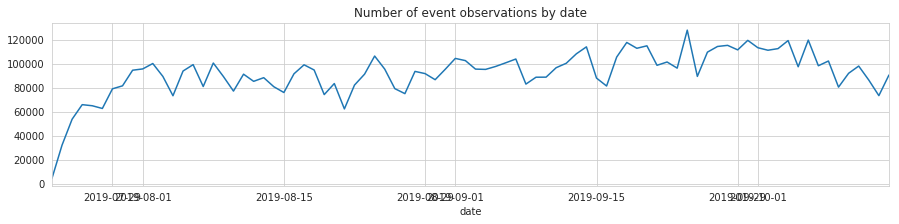

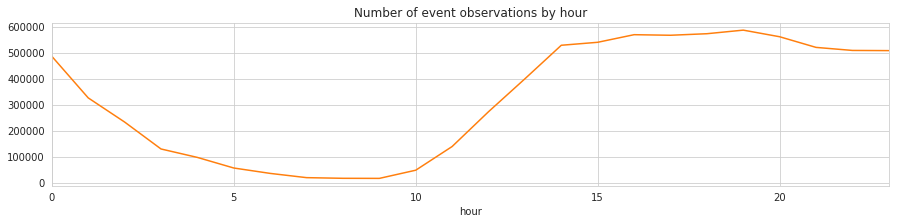

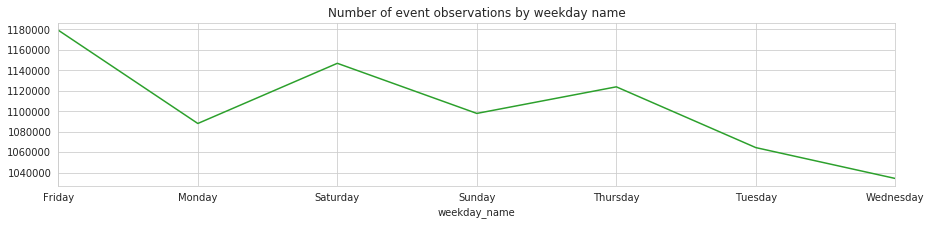

In [32]:
train.groupby('date')['event_id'].agg('count').plot(figsize=(15,3), title="Number of event observations by date", color=my_pal[0])
plt.show()
train.groupby('hour')['event_id'].agg('count').plot(figsize=(15,3), title="Number of event observations by hour", color=my_pal[1])
plt.show()
train.groupby('weekday_name')['event_id'].agg('count').plot(figsize=(15,3), title="Number of event observations by weekday name", color=my_pal[2])
plt.show()

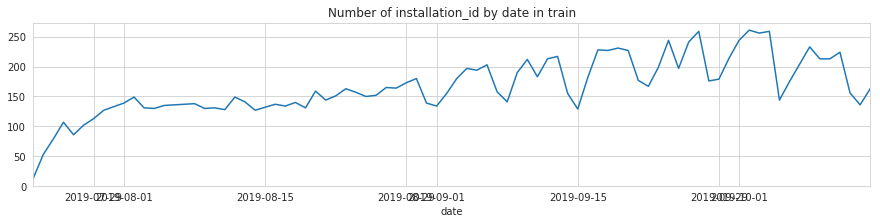

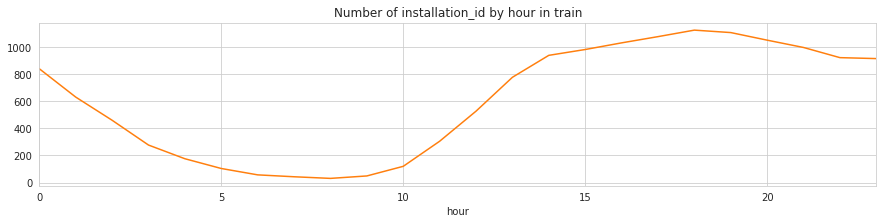

In [33]:
# can be seen as cyclic trend in the middle part of analysis period
train.groupby('date')['installation_id'].agg(lambda x: len(x.unique())).plot(figsize=(15,3), title="Number of installation_id by date in train", color=my_pal[0])
plt.show()
# can be seen as cyclic trend in the middle part of analysis period
train.groupby('hour')['installation_id'].agg(lambda x: len(x.unique())).plot(figsize=(15,3), title="Number of installation_id by hour in train", color=my_pal[1])
plt.show()

In [34]:
all_df = pd.concat([train[["date", "hour", "installation_id"]], test[["date", "hour", "installation_id"]]])

In [35]:
all_df.shape

(8890972, 3)

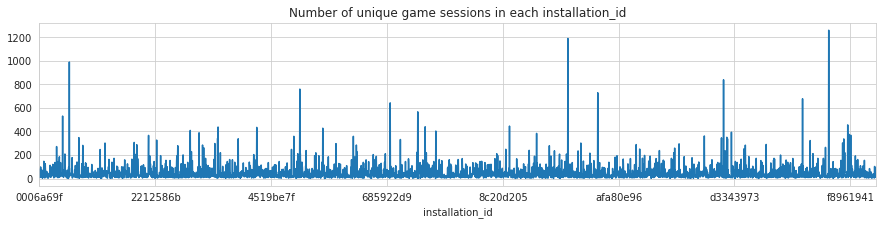

In [36]:
# several outliers
train.groupby("installation_id")["game_session"].agg(lambda x: len(x.unique())).plot(figsize=(15,3), title="Number of unique game sessions in each installation_id", color=my_pal[0])
plt.show()

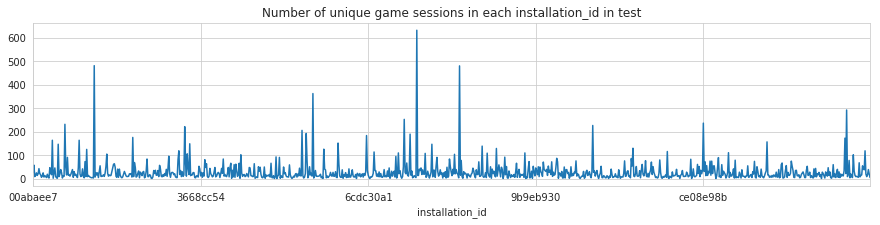

In [37]:
test.groupby("installation_id")["game_session"].agg(lambda x: len(x.unique())).plot(figsize=(15,3), title="Number of unique game sessions in each installation_id in test", color=my_pal[0])
plt.show()

In [38]:
tmp = train.groupby("installation_id")["game_session"].agg(lambda x: len(x.unique())).reset_index()
tmp[tmp.game_session >= 800]

,installation_id,game_session
129,08987c08,990
2281,9f399a3a,1190
2953,cff5a334,839
3407,f1c21eda,1260


In [39]:
print(train_labels[train_labels.installation_id == "08987c08"].shape)
print(train_labels[train_labels.installation_id == "9f399a3a"].shape)
print(train_labels[train_labels.installation_id == "cff5a334"].shape)
print(train_labels[train_labels.installation_id == "f1c21eda"].shape)

(156, 7)
(78, 7)
(11, 7)
(129, 7)


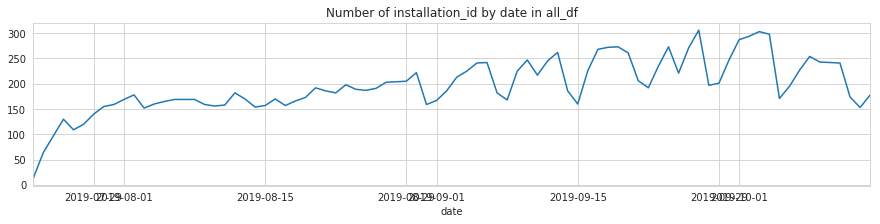

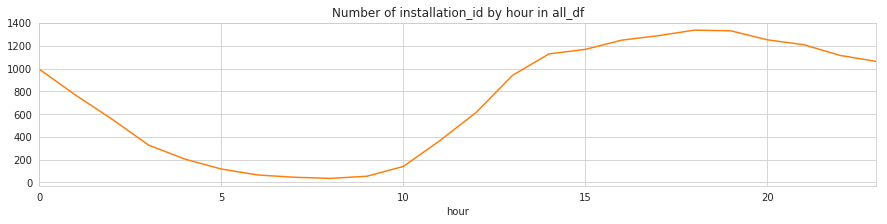

In [40]:
# can be seen as cyclic trend in the middle part of analysis period
all_df.groupby('date')['installation_id'].agg(lambda x: len(x.unique())).plot(figsize=(15,3), title="Number of installation_id by date in all_df", color=my_pal[0])
plt.show()
# can be seen as cyclic trend in the middle part of analysis period
all_df.groupby('hour')['installation_id'].agg(lambda x: len(x.unique())).plot(figsize=(15,3), title="Number of installation_id by hour in all_df", color=my_pal[1])
plt.show()

In [41]:
tmp = train_labels.groupby("installation_id").count()["accuracy_group"].reset_index().sort_values("accuracy_group")
tmp[tmp.accuracy_group != 1].tail(10)

,installation_id,accuracy_group
100,063e3e02,46
651,2d6d1ecd,47
689,2ffb27f9,48
938,416398f8,49
2146,96979008,64
262,123a40a1,64
2029,8e44d2de,72
2281,9f399a3a,78
3407,f1c21eda,129
129,08987c08,156


In [42]:
# 95% of train_labels data with less than or equal to 15 evaluation targets 
(tmp["accuracy_group"].value_counts() / tmp.shape[0]).head(20)

1     0.284173
2     0.175152
3     0.122302
4     0.086054
5     0.070836
6     0.050083
7     0.037355
8     0.030991
9     0.020753
10    0.018262
11    0.013282
13    0.011345
12    0.010515
15    0.010238
14    0.008301
17    0.005811
16    0.005257
18    0.004704
19    0.003597
20    0.003320
Name: accuracy_group, dtype: float64

In [43]:
# play date
train[train.installation_id == "123a40a1"]["date"].unique()

array([datetime.date(2019, 7, 24), datetime.date(2019, 7, 25),
       datetime.date(2019, 7, 26), datetime.date(2019, 7, 27),
       datetime.date(2019, 7, 28), datetime.date(2019, 7, 29),
       datetime.date(2019, 7, 30), datetime.date(2019, 7, 31),
       datetime.date(2019, 8, 1), datetime.date(2019, 8, 2),
       datetime.date(2019, 8, 5), datetime.date(2019, 8, 6),
       datetime.date(2019, 8, 7), datetime.date(2019, 8, 9),
       datetime.date(2019, 8, 10), datetime.date(2019, 8, 19),
       datetime.date(2019, 9, 5), datetime.date(2019, 10, 2)],
      dtype=object)

# ideas of FE

In [44]:
def date_calc(tmp):
    tmp = list(tmp)
    all_login_days = len(tmp)
    max_cont_days = 1
    count = 1
    prev = tmp[0]
    for i in range(1,len(tmp)):
        if (tmp[i] - prev).days == 1:
            count += 1
            max_cont_days = max(max_cont_days, count)
        else:
            count = 1
        prev = tmp[i]
    return all_login_days, max_cont_days
tmp = set(train[train.installation_id == "123a40a1"]["date"].unique())
date_calc(tmp)

(18, 2)

In [45]:
# check if the play is follwed by recommended learning order
mushroom_sorter_recommend_order = {"Welcome to Lost Lagoon!": "Clip" ,"Tree Top City - Level 1": "Clip",
"Ordering Spheres": "Clip",  "All Star Sorting": "Game", "Costume Box": "Clip",
"Fireworks (Activity)": "Activity", "12 Monkeys": "Clip", "Tree Top City - Level 2": "Clip",
"Flower Waterer (Activity)": "Activity", "Pirate's Tale": "Clip"}

bird_measurer_recommend_order = {"Air Show": "Game", "Treasure Map": "Clip", "Tree Top City - Level 3": "Clip",
"Crystals Rule": "Game", "Rulers": "Clip", "Bug Measurer (Activity)": "Activity"}

cauldron_filter_recommend_order = {"Magma Peak - Level 1": "Clip", "Sandcastle Builder (Activity)": "Activity", "Slop Problem": "Clip",
"Scrub-A-Dub" :"Game", "Watering Hole (Activity)": "Activity", "Magma Peak - Level 2": "Clip",
"Dino Drink": "Game", "Bubble Bath": "Game", "Bottle Filler (Activity)": "Activity", "Dino Dive": "Game"}
    
cart_balancer_recommend_order = {"Crystal Caves - Level 1": "Clip", "Chow Time": "Game", "Balancing Act": "Clip",
"Chicken Balancer (Activity)": "Activity", "Lifting Heavy Things": "Clip", "Crystal Caves - Level 2":"Clip",
"Honey Cake": "Clip", "Happy Camel": "Game"}
    
chest_sorter_recommend_order = {"Leaf Leader": "Game", "Crystal Caves - Level 3": "Clip", "Heavy, Heavier, Heaviest": "Clip",
"Pan Balance": "Game", "Egg Dropper (Activity)": "Activity"}

In [46]:
%%time
# average  game_time in world per user
tmp = (train.groupby(["installation_id", "game_session"]).agg(["max"])[["world", "game_time"]]).reset_index()
tmp.columns = ["installation_id", "game_session", "world", "game_time"]
tmp.groupby(["installation_id", "world"]).agg("sum")["game_time"].reset_index()
tmp = tmp.groupby(["installation_id", "world"]).agg("sum")["game_time"].reset_index()
tmp = tmp.groupby(["world"]).agg("mean")["game_time"].reset_index() 
tmp["game_time"] /= 1000
tmp

CPU times: user 3min 30s, sys: 2.23 s, total: 3min 32s
Wall time: 3min 32s


,world,game_time
0,CRYSTALCAVES,1341.861993
1,MAGMAPEAK,2242.139182
2,NONE,0.000000
3,TREETOPCITY,1438.707839


In [47]:
tmp_df = (test.groupby(["installation_id", "game_session"]).agg(["max"])[["world", "game_time"]]).reset_index()
tmp_df.columns = ["installation_id", "game_session", "world", "game_time"]
tmp_df.groupby(["installation_id", "world"]).agg("sum")["game_time"].reset_index()
tmp_df = tmp_df.groupby(["installation_id", "world"]).agg("sum")["game_time"].reset_index()
tmp_df = tmp_df.groupby(["world"]).agg("mean")["game_time"].reset_index() 
tmp_df["game_time"] /= 1000
tmp_df

,world,game_time
0,CRYSTALCAVES,707.358374
1,MAGMAPEAK,1420.295106
2,NONE,0.000000
3,TREETOPCITY,973.606114


In [48]:
#time_spent_in_world = {str(ele): 0 for ele in list_of_worlds if ele != "NONE"}
#if session_world = 0:
#    time_spent_in_world['MAGMAPEAK'] += (session.iloc[-1]["game_time"] - session.iloc[0]["game_time"]) / 1000
#elif session_world = 1:
#    time_spent_in_world['CRYSTALCAVES'] += (session.iloc[-1]["game_time"] - session.iloc[0]["game_time"]) / 1000
#elif session_world = 3:
#    time_spent_in_world['TREETOPCITY'] += session.iloc[-1]["game_time"] - session.iloc[0]["game_time"] / 1000
#else:
#    pass
#features.update(time_spent_in_world.copy())

In [49]:
#mushroom_sorter_recommend_order = ["Welcome to Lost Lagoon!", "Tree Top City - Level 1","Ordering Spheres",  "All Star Sorting", "Costume Box",
#"Fireworks (Activity)", "12 Monkeys", "Tree Top City - Level 2", "Flower Waterer (Activity)", "Pirate's Tale"]
#bird_measurer_recommend_order = ["Air Show", "Treasure Map", "Tree Top City - Level 3","Crystals Rule", "Rulers", "Bug Measurer (Activity)"]
#cauldron_filter_recommend_order = ["Magma Peak - Level 1", "Sandcastle Builder (Activity)", "Slop Problem",
#"Scrub-A-Dub", "Watering Hole (Activity)", "Magma Peak - Level 2","Dino Drink", "Bubble Bath", "Bottle Filler (Activity)", "Dino Dive"]
#cart_balancer_recommend_order = ["Crystal Caves - Level 1", "Chow Time", "Balancing Act",
#"Chicken Balancer (Activity)", "Lifting Heavy Things", "Crystal Caves - Level 2","Honey Cake", "Happy Camel"]
#chest_sorter_recommend_order = ["Leaf Leader", "Crystal Caves - Level 3", "Heavy, Heavier, Heaviest","Pan Balance", "Egg Dropper (Activity)"]

#mushroom_sorter_check = {ele: 0 for ele in mushroom_sorter_recommend_order}
#if activities_labels[session_title] in mushroom_sorter_check.keys():
#    mushroom_sorter_check[activities_labels[session_title]] = 1
#bird_measurer_check = {ele: 0 for ele in bird_measurer_recommend_order}
#if activities_labels[session_title] in bird_measurer_check.keys():
#    bird_measurer_check[activities_labels[session_title]] = 1
#cart_balancer_check = {ele: 0 for ele in cart_balancer_recommend_order}
#if activities_labels[session_title] in cart_balancer_check.keys():
#    cart_balancer_check[activities_labels[session_title]] = 1
#chest_sorter_check = {ele: 0 for ele in chest_sorter_recommend_order}
#if activities_labels[session_title] in chest_sorter_check.keys():
#    chest_sorter_check[activities_labels[session_title]] = 1
    
#if sum(mushroom_sorter_check.values()) == len(mushroom_sorter_check):
#    features["mushroom_complete"] = cumulative_gametime
#else:
#    features["mushroom_complete"] = -999

In [50]:
length_list = [19, 17,  61 ,-999,61, -999, 109, 25, -999, 80, -999, -999, 156, 26, -999, 126, -999, -999, 20, -999, 60, -999, 22, -999,
              -999, -999, -999, -999, 18, -999, 72, -999, 118, 24, 142, -999, -999, -999, 19, 61] 
title_list = ["Welcome to Lost Lagoon!",  "Tree Top City - Level 1", "Ordering Spheres", "All Star Sorting",  "Costume Box", "Fireworks (Activity)", 
              "12 Monkeys", "Tree Top City - Level 2", "Flower Waterer (Activity)", "Pirate's Tale",  "Mushroom Sorter (Assessment)",  "Air Show",  
              "Treasure Map", "Tree Top City - Level 3", "Crystals Rule", "Rulers", "Bug Measurer (Activity)",  "Bird Measurer (Assessment)",  
              "Magma Peak - Level 1",   "Sandcastle Builder (Activity)",  "Slop Problem",  "Scrub-A-Dub",  "Watering Hole (Activity)", 
              "Magma Peak - Level 2" , "Dino Drink", "Bubble Bath",  "Bottle Filler (Activity)",  "Dino Dive", "Cauldron Filler (Assessment)", 
              "Crystal Caves - Level 1", "Chow Time", "Balancing Act",  "Chicken Balancer (Activity)",  "Lifting Heavy Things", 
              "Crystal Caves - Level 2" , "Honey Cake" ,  "Happy Camel", "Cart Balancer (Assessment)",  "Leaf Leader",  "Crystal Caves - Level 3",  
              "Heavy, Heavier, Heaviest"]
title_list = pd.DataFrame(title_list)
length_list = pd.DataFrame(length_list)
length_df = pd.concat([title_list, length_list], axis=1)
length_df.columns = ["title", "length"]
tmp = pd.merge(train, length_df)

# state transitions

In [51]:
list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
train['title'] = train['title'].map(activities_map)
test['title'] = test['title'].map(activities_map)

In [52]:
def transition_matrix_mod(transitions):
    n = 1+ max(transitions["title"]) #number of states

    M = [[0]*n for _ in range(n)]
    
    for i, session in transitions.groupby('installation_id', sort=False):
        for (k,j) in zip(session["title"],session.iloc[1:]["title"]):
            M[k][j] += 1

    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return pd.DataFrame(M)
m_train = transition_matrix_mod(train[["title", "game_session", "installation_id"]].drop_duplicates("game_session"))
m_test = transition_matrix_mod(test[["title", "game_session", "installation_id"]].drop_duplicates("game_session"))

In [53]:
def transition_matrix(transitions):
    n = 1+ max(transitions) #number of states

    M = [[0]*n for _ in range(n)]

    for (i,j) in zip(transitions,transitions[1:]):
        M[i][j] += 1

    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return pd.DataFrame(M)
m_train = transition_matrix(train["title"])
m_test = transition_matrix(test["title"])

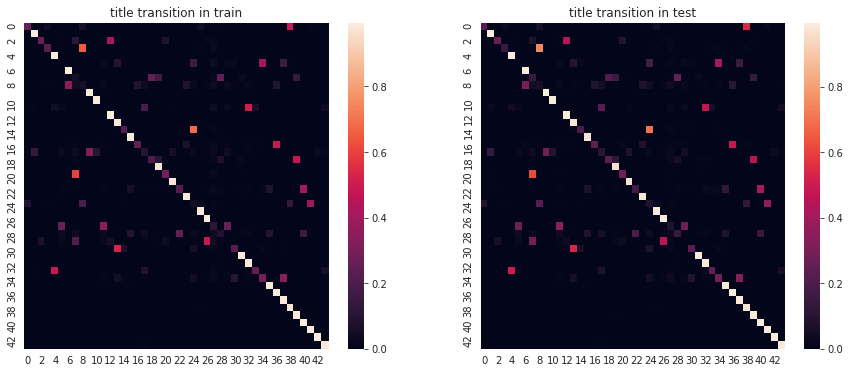

In [54]:
# heatmap of title transition: no big difference in the transtion tendency
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title("title transition in train")
sns.heatmap(m_train)
plt.subplot(1,2,2)
plt.title("title transition in test")
sns.heatmap(m_test)

In [55]:
sample = train[train.installation_id == "0006a69f"].copy()

In [56]:
def calc_transition(tmp, m):
    prob_list = []
    for i in range(tmp.shape[0]-1):
        prob_list.append((m.iloc[tmp[i]][tmp[i+1]] == max_prob[tmp[i]]))
    return sum(prob_list)
calc_transition(sample["title"], m_train)

NameError: name 'max_prob' is not defined

In [57]:
#np.random.seed(84)
#for title,title_train_labels in train_labels.groupby('title'): # title_train_labelsがtitleごとで分けたtrain_labelsの各dfを表す
#    for iid in title_train_labels.installation_id.sample(1):
#        seq    = train[train.installation_id==iid].groupby('game_session',sort=False).title.first().values
#        seq_world = train[train.installation_id==iid].groupby('game_session',sort=False).world.first().values
#        print(iid, seq, seq_world)

In [58]:
# but slow
#for iid, session in tqdm(zip(train_labels["installation_id"], train_labels["game_session"])):
#    ind = train[train.game_session == session].index[-1]
#    tmp = train[(train.installation_id==iid) & (train.index <= ind)].groupby('game_session',sort=False)
#    seq    = tmp.title.first().values
#    seq_world = tmp.world.first().values
    #print(iid, session)
    #print(seq, seq_world)

# pretty json

In [59]:
import json
from IPython.display import display, HTML

def pretty_json(data):
    return json.dumps(json.loads(data), indent=2, sort_keys=False)

def pretty_display(df):
    style = """

    """
    return display(HTML(df.to_html().replace('\\n', '<br>') + style))

In [60]:
train_labels.installation_id.unique()

array(['0006a69f', '0006c192', '00129856', ..., 'ffc90c32', 'ffd2871d',
       'ffeb0b1b'], dtype=object)

In [61]:
a = list(train_labels.iloc[:5]["game_session"])
sample = train[train.installation_id == '0006a69f'].copy()
#sample = sample[sample.type=="Activity"].copy()
sample["event_data_pretty"] = sample["event_data"].map(pretty_json)
sample = sample[sample.type == "Assessment"]
sample = sample[sample.game_session.isin(a)]
pretty_display(sample[["game_session", "timestamp", "event_count", "event_code", "game_time", "title", "type", "world", "event_data_pretty"]])

,game_session,timestamp,event_count,event_code,game_time,title,type,world,event_data_pretty
647,901acc108f55a5a1,2019-08-06 05:22:01.344000+00:00,1,2000,0,38,Assessment,TREETOPCITY,"{ ""version"": ""1.0"", ""event_count"": 1, ""game_time"": 0, ""event_code"": 2000}"
648,901acc108f55a5a1,2019-08-06 05:22:01.400000+00:00,2,2025,37,38,Assessment,TREETOPCITY,"{ ""event_count"": 2, ""game_time"": 37, ""event_code"": 2025}"
649,901acc108f55a5a1,2019-08-06 05:22:01.403000+00:00,3,3010,37,38,Assessment,TREETOPCITY,"{ ""description"": ""Pull three mushrooms out of the ground and order them from shortest to tallest!"", ""identifier"": ""Dot_PullMushrooms"", ""media_type"": ""audio"", ""total_duration"": 3000, ""event_count"": 3, ""game_time"": 37, ""event_code"": 3010}"
650,901acc108f55a5a1,2019-08-06 05:22:05.242000+00:00,4,3110,3901,38,Assessment,TREETOPCITY,"{ ""description"": ""Pull three mushrooms out of the ground and order them from shortest to tallest!"", ""identifier"": ""Dot_PullMushrooms"", ""media_type"": ""audio"", ""duration"": 3864, ""event_count"": 4, ""game_time"": 3901, ""event_code"": 3110}"
651,901acc108f55a5a1,2019-08-06 05:22:05.244000+00:00,5,3010,3901,38,Assessment,TREETOPCITY,"{ ""description"": ""To pick a mushroom, pull it out of the ground with your finger!"", ""identifier"": ""Dot_PickFinger"", ""media_type"": ""audio"", ""total_duration"": 2680, ""event_count"": 5, ""game_time"": 3901, ""event_code"": 3010}"
652,901acc108f55a5a1,2019-08-06 05:22:07.812000+00:00,6,4025,6475,38,Assessment,TREETOPCITY,"{ ""height"": 4, ""coordinates"": { ""x"": 329, ""y"": 550, ""stage_width"": 1015, ""stage_height"": 762 }, ""event_count"": 6, ""game_time"": 6475, ""event_code"": 4025}"
653,901acc108f55a5a1,2019-08-06 05:22:07.812000+00:00,7,3110,6475,38,Assessment,TREETOPCITY,"{ ""description"": ""To pick a mushroom, pull it out of the ground with your finger!"", ""identifier"": ""Dot_PickFinger"", ""media_type"": ""audio"", ""duration"": 2574, ""event_count"": 7, ""game_time"": 6475, ""event_code"": 3110}"
654,901acc108f55a5a1,2019-08-06 05:22:07.816000+00:00,8,3021,6475,38,Assessment,TREETOPCITY,"{ ""description"": ""That's one!"", ""identifier"": ""Dot_ThatsOne"", ""media_type"": ""audio"", ""total_duration"": 600, ""event_count"": 8, ""game_time"": 6475, ""event_code"": 3021}"
655,901acc108f55a5a1,2019-08-06 05:22:08.427000+00:00,9,3121,7084,38,Assessment,TREETOPCITY,"{ ""description"": ""That's one!"", ""identifier"": ""Dot_ThatsOne"", ""media_type"": ""audio"", ""duration"": 609, ""event_count"": 9, ""game_time"": 7084, ""event_code"": 3121}"
656,901acc108f55a5a1,2019-08-06 05:22:09.742000+00:00,10,4025,8400,38,Assessment,TREETOPCITY,"{ ""height"": 1, ""coordinates"": { ""x"": 176, ""y"": 526, ""stage_width"": 1015, ""stage_height"": 762 }, ""event_count"": 10, ""game_time"": 8400, ""event_code"": 4025}"


In [62]:
train_labels.head(10)

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3
5,197a373a77101924,0006c192,Cauldron Filler (Assessment),1,0,1.0,3
6,957406a905d59afd,0006c192,Bird Measurer (Assessment),1,1,0.5,2
7,b2297d292892745a,0006c192,Mushroom Sorter (Assessment),0,4,0.0,0
8,ae691ec5ad5652cf,00129856,Bird Measurer (Assessment),1,0,1.0,3
9,7b536271e99518f0,001d0ed0,Bird Measurer (Assessment),0,5,0.0,0


- data start time 2019-08-06T04:57:18.904Z
- 1482, 2280, 2431, 
- 2019-08-06T05:22:01.344Z 901acc108f55a5a1 treetopolicy
- 2019-08-06T05:22:41.147Z
- 758
- 2019-08-06T05:35:19.167Z 77b8ee947eb84b4e treetopolicy
- 2019-08-06T05:36:51.915Z	
- 58
- 2019-08-06T05:37:50.020Z 6bdf9623adc94d89 treetopolicy
- 2019-08-06T05:38:16.835Z
- 14h56m37s 50400+3360+37=53796
- ** 2019-08-06T20:34:35.357Z 
- ** 2019-08-06T20:34:44.115Z e7e7db2a241eadcc ****
- 9 sec: assessmentには入ったけど評価には含まれない部分があった！！！
- 2019-08-06T20:34:53.812Z 9501794defd84e4d treetopolicy
- 2019-08-06T20:35:25.648Z
- 873
- 2019-08-06T20:49:59.095Z a9ef3ecb3d1acc6a

In [63]:
sample = train[train.installation_id == '0006a69f'].copy()
sample["event_data_pretty"] = sample["event_data"].map(pretty_json)
pretty_display(sample[["game_session", "timestamp", "event_count", "event_code", "game_time", "title", "type", "world", "event_data_pretty"]])

,game_session,timestamp,event_count,event_code,game_time,title,type,world,event_data_pretty
0,34ba1a28d02ba8ba,2019-08-06 04:57:18.904000+00:00,1,2000,0,27,Clip,NONE,"{ ""event_code"": 2000, ""event_count"": 1}"
1,4b57c9a59474a1b9,2019-08-06 04:57:45.301000+00:00,1,2000,0,11,Clip,MAGMAPEAK,"{ ""event_code"": 2000, ""event_count"": 1}"
2,2b9d5af79bcdb79f,2019-08-06 04:58:14.538000+00:00,1,2000,0,32,Activity,MAGMAPEAK,"{ ""version"": ""1.0"", ""event_count"": 1, ""game_time"": 0, ""event_code"": 2000}"
3,2b9d5af79bcdb79f,2019-08-06 04:58:14.615000+00:00,2,3010,29,32,Activity,MAGMAPEAK,"{ ""description"": ""Let's build a sandcastle! First, fill up your mold with sand! You can use the shovel here. The mold gives the sand its shape!"", ""identifier"": ""Dot_LetsSandcastle,Dot_FillMold,Dot_MoldShape"", ""media_type"": ""audio"", ""total_duration"": 6758, ""event_count"": 2, ""game_time"": 29, ""event_code"": 3010}"
4,2b9d5af79bcdb79f,2019-08-06 04:58:16.680000+00:00,3,4070,2137,32,Activity,MAGMAPEAK,"{ ""coordinates"": { ""x"": 273, ""y"": 650, ""stage_width"": 1015, ""stage_height"": 762 }, ""event_count"": 3, ""game_time"": 2137, ""event_code"": 4070}"
5,2b9d5af79bcdb79f,2019-08-06 04:58:18.474000+00:00,4,4070,3937,32,Activity,MAGMAPEAK,"{ ""coordinates"": { ""x"": 863, ""y"": 237, ""stage_width"": 1015, ""stage_height"": 762 }, ""event_count"": 4, ""game_time"": 3937, ""event_code"": 4070}"
6,2b9d5af79bcdb79f,2019-08-06 04:58:19.365000+00:00,5,4070,4820,32,Activity,MAGMAPEAK,"{ ""coordinates"": { ""x"": 817, ""y"": 617, ""stage_width"": 1015, ""stage_height"": 762 }, ""event_count"": 5, ""game_time"": 4820, ""event_code"": 4070}"
7,2b9d5af79bcdb79f,2019-08-06 04:58:21.490000+00:00,6,3110,6954,32,Activity,MAGMAPEAK,"{ ""description"": ""Let's build a sandcastle! First, fill up your mold with sand! You can use the shovel here. The mold gives the sand its shape!"", ""identifier"": ""Dot_LetsSandcastle,Dot_FillMold,Dot_MoldShape"", ""media_type"": ""audio"", ""duration"": 6925, ""event_count"": 6, ""game_time"": 6954, ""event_code"": 3110}"
8,2b9d5af79bcdb79f,2019-08-06 04:58:22.732000+00:00,7,4070,8187,32,Activity,MAGMAPEAK,"{ ""coordinates"": { ""x"": 809, ""y"": 180, ""stage_width"": 1015, ""stage_height"": 762 }, ""event_count"": 7, ""game_time"": 8187, ""event_code"": 4070}"
9,2b9d5af79bcdb79f,2019-08-06 04:58:23.295000+00:00,8,4030,8745,32,Activity,MAGMAPEAK,"{ ""size"": 0, ""coordinates"": { ""x"": 782, ""y"": 207, ""stage_width"": 1015, ""stage_height"": 762 }, ""event_count"": 8, ""game_time"": 8745, ""event_code"": 4030}"


In [64]:
train["exit_type"] = train["event_data"].apply(lambda x: json.loads(x)["exit_type"] if "\"exit_type\"" in x else 0)

In [65]:
train["exit_type"].value_counts()

0                   7731631
game_completed         2925
closed_container          1
left_site                 1
Name: exit_type, dtype: int64

In [66]:
sample = train[train.type=="Game"].copy()
sample = sample[sample.world=="MAGMAPEAK"]

In [67]:
sample = train[train.type=="Game"].copy()
sample.groupby("world").agg("mean")["level"]

KeyError: 'level'

In [68]:
sample = train[train.type=="Game"].copy()
sample.groupby("world").agg("mean")["round"]

KeyError: 'round'

In [69]:
sample = train[train.type=="Activity"].copy()
sample.groupby("world").agg("mean")["level"]

KeyError: 'level'

In [70]:
sample = train[train.type=="Activity"].copy()
sample.groupby("world").agg("mean")["round"]

KeyError: 'round'

In [71]:
extracted_event_data[extracted_event_data.total_duration >= 0]["event_code"].value_counts()

NameError: name 'extracted_event_data' is not defined

In [72]:
extracted_event_data[extracted_event_data.duration >= 0]["event_code"].value_counts()

NameError: name 'extracted_event_data' is not defined

In [73]:
train[train.event_code == 4020]["event_id"].unique()

array(['84538528', '5c3d2b2f', '2dc29e21', 'e694a35b', 'de26c3a6',
       '5f0eb72c', '28f975ea', '86c924c4', 'd2e9262e', '74e5f8a7',
       '3bb91dda', '90efca10', '8fee50e2', '4ef8cdd3', 'c0415e5c',
       '30614231', '499edb7c', '8af75982', '5c2f29ca', '804ee27f',
       '0db6d71d', '461eace6', '262136f4'], dtype=object)

# date

In [74]:
tmp = train["date"].value_counts().reset_index()
tmp.columns = ["date", "count"]
tmp.sort_values("date", ascending=False)

,date,count
50,2019-10-14,90471
75,2019-10-13,73321
59,2019-10-12,86293
31,2019-10-11,97938
45,2019-10-10,91916
68,2019-10-09,80411
21,2019-10-08,102139
30,2019-10-07,98201
1,2019-10-06,119543
33,2019-10-05,97352


In [75]:
tmp = test["date"].value_counts().reset_index()
tmp.columns = ["date", "count"]
tmp.sort_values("date", ascending=False)

,date,count
82,2019-10-14,6260
75,2019-10-13,8064
44,2019-10-12,12705
79,2019-10-11,6898
32,2019-10-10,14545
42,2019-10-09,12981
66,2019-10-08,9836
81,2019-10-07,6394
80,2019-10-06,6787
70,2019-10-05,9179


# dummy train

In [76]:
dummy_train.shape[0]

NameError: name 'dummy_train' is not defined

In [77]:
dummy_train.installation_id.unique()

NameError: name 'dummy_train' is not defined

In [78]:
sample = dummy_train[dummy_train.installation_id == '565c0f50'].copy()
sample["event_data"] = sample["event_data"].map(pretty_json)
#sample.title.unique()
pretty_display(sample)

NameError: name 'dummy_train' is not defined

# play time

In [79]:
train.groupby("installation_id")["hour"].value_counts().head(50)#.reset_index()#.sort_values("hour").head(100)

installation_id  hour
0006a69f         5       1654
                 20       691
                 16       640
                 18       485
                 17       227
                 4        104
0006c192         15      1351
                 0        599
                 1        154
                 13       120
00129856         16       827
                 3          3
001d0ed0         13       595
                 14       315
                 19       118
00225f67         0        555
                 23       402
00279ac5         14      1774
                 18      1440
                 13       811
                 12       602
                 19       328
                 20       309
                 23       210
                 0         12
002db7e3         20      1425
                 21       921
                 23       572
                 19       254
                 0        193
                 1         84
003372b0         13      1807
                 1

In [80]:
train["hour"] = train["hour"].replace(0, 24)

In [81]:
train.groupby("installation_id")[#.reset_index()#.sort_values("hour").head(100)
#train["periods"] = train[]

SyntaxError: unexpected EOF while parsing (<ipython-input-81-79c45fdc3abe>, line 2)

In [82]:
game_hour = train.groupby("installation_id").agg(["max","min"])["hour"].reset_index(drop=False)
game_hour["range"] = game_hour["max"] - game_hour["min"]

In [83]:
train[train.installation_id == "0006a69f"]

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date,hour,weekday_name,exit_type
0,27253bdc,34ba1a28d02ba8ba,2019-08-06 04:57:18.904000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,27,Clip,NONE,2019-08-06,4,Tuesday,0
1,27253bdc,4b57c9a59474a1b9,2019-08-06 04:57:45.301000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0,11,Clip,MAGMAPEAK,2019-08-06,4,Tuesday,0
2,77261ab5,2b9d5af79bcdb79f,2019-08-06 04:58:14.538000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0,32,Activity,MAGMAPEAK,2019-08-06,4,Tuesday,0
3,b2dba42b,2b9d5af79bcdb79f,2019-08-06 04:58:14.615000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29,32,Activity,MAGMAPEAK,2019-08-06,4,Tuesday,0
4,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:16.680000+00:00,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137,32,Activity,MAGMAPEAK,2019-08-06,4,Tuesday,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3796,832735e1,0721802df0531701,2019-08-29 16:33:53.227000+00:00,"{""description"":""Let's warm up. Tap a dinosaur ...",0006a69f,11,3010,23145,42,Game,MAGMAPEAK,2019-08-29,16,Thursday,0
3797,ab3136ba,0721802df0531701,2019-08-29 16:33:56.880000+00:00,"{""description"":""Let's warm up. Tap a dinosaur ...",0006a69f,12,3110,26804,42,Game,MAGMAPEAK,2019-08-29,16,Thursday,0
3798,832735e1,0721802df0531701,2019-08-29 16:34:11.881000+00:00,"{""description"":""Let's warm up. Tap a dinosaur ...",0006a69f,13,3010,41805,42,Game,MAGMAPEAK,2019-08-29,16,Thursday,0
3799,ab3136ba,0721802df0531701,2019-08-29 16:34:15.480000+00:00,"{""description"":""Let's warm up. Tap a dinosaur ...",0006a69f,14,3110,45405,42,Game,MAGMAPEAK,2019-08-29,16,Thursday,0


In [84]:
df1 = train.iloc[:1758,:].copy()
df2 = train.iloc[1758:3801,:].copy()

In [85]:
df1["world"].value_counts()

TREETOPCITY    1028
MAGMAPEAK       728
NONE              2
Name: world, dtype: int64

In [86]:
df2["world"].value_counts()

MAGMAPEAK      1182
TREETOPCITY     859
NONE              2
Name: world, dtype: int64

In [87]:
set(df2["title"].unique()) - set(df1["title"].unique()) 

{42}

# train_label

In [88]:
train_labels["num_correct"].value_counts()

1    13461
0     4229
Name: num_correct, dtype: int64

# direct assessment try

In [89]:
train.installation_id.nunique()

3614

In [90]:
random_id = []
for i, session in train.groupby("installation_id"):
    if "Assessment" in list(session.iloc[:3]["type"]):
        random_id.append(i)

In [91]:
total = 0
for i in random_id:
    print(i, train_labels[train_labels.installation_id == i].shape[0])
    total += train_labels[train_labels.installation_id == i].shape[0]
total

00129856 1
00a53963 1
00e536bf 8
02490b06 1
03cd458d 2
0478b042 12
04de2aae 3
077173b2 4
08062502 1
0938a8eb 1
0b2fe8e3 7
0bf95a69 1
0d09ed83 6
0e1506ef 2
0e31fa8d 6
0ef56279 3
0f2e23b4 1
108634a9 1
1091d87b 4
11c7b926 10
12887b75 1
12a9a35e 1
12d91fc7 3
16276a94 3
1711805c 6
182b7671 1
183bed63 6
18706205 3
19a910b3 5
1a97afc6 9
1ae140f6 1
1bfc9ff2 5
1c0934dd 7
1dbbd324 1
1df9a1d0 6
1edecf49 1
21691319 3
23612836 2
24c2e756 7
281e0b40 4
2977c68b 4
2a222143 1
2c183ed4 3
2c4f896e 1
2cd0e982 2
2d4a9118 4
2e280a49 6
321fbc89 2
369a195a 3
376980a2 3
37795aab 1
3812b497 5
38509434 1
3976c33d 8
3dbbde1a 6
3dbdfa87 5
42aedefa 6
436d5ed2 1
4378b5ec 3
43ccecc0 1
45d94477 6
466a6ad4 3
475b2709 13
484af773 3
48cb2879 1
48d57f4a 10
49bcf879 4
49ee3af8 1
4c5f57f8 2
4c8acb25 2
4d2f1f5e 1
4daf4f50 2
4dd2c3f8 3
4e51af2e 1
50633b1a 1
50e767ea 1
51e81753 7
52f9769b 1
5484f705 2
549cd3e0 1
57bbe2e1 7
57ee528d 5
5afef704 6
5b19c8d2 3
5d7c762f 1
5fe2e727 4
60283b63 3
60496d03 2
62a24831 2
639e98d0 4
63b921

850

# rasch model

In [92]:
all_df = pd.concat([train, test], axis=0)

In [93]:
del train
del test

In [94]:
all_df["true"] = train["event_data"].apply(lambda x: 1 if '"correct":true' in x else 0)
all_df["false"] = train["event_data"].apply(lambda x: 1 if '"correct":false' in x else 0)

NameError: name 'train' is not defined

In [95]:
game_title = all_df[all_df.type=="Game"]["title"].unique()
assess_title = all_df[all_df.type=="Assessment"]["title"].unique()

In [96]:
game_assess_title = []
for i in game_title:
    game_assess_title.append(i)
for i in assess_title:
    game_assess_title.append(i)

In [97]:
game_world = train[["title", "world"]].drop_duplicates()

NameError: name 'train' is not defined

In [98]:
tmp = all_df.groupby(["title"]).agg("sum")[["true", "false"]].reset_index(drop=False)
tmp = tmp[tmp.title.isin(game_assess_title)]
tmp["accuracy_rate"] = tmp["true"] / (tmp["true"]+tmp["false"])
tmp["abi_diff"] = np.log(tmp["accuracy_rate"]/(1-tmp["accuracy_rate"]))
tmp["ave_player_abi"] = 1 # assume average player' ability is 1
tmp["difficulty"] = tmp["ave_player_abi"] - tmp["abi_diff"]

sample_user = all_df[all_df.installation_id == "0006a69f"]
tmp_sample = sample_user.groupby(["title"]).agg("sum")[["true", "false"]].reset_index(drop=False)
tmp_sample = tmp_sample[tmp_sample.title.isin(game_assess_title)]
tmp_sample["accuracy_rate"] = tmp_sample["true"] / (tmp_sample["true"]+tmp_sample["false"])
tmp_sample["abi_diff"] = np.log(tmp_sample["accuracy_rate"]/(1-tmp_sample["accuracy_rate"]))
tmp_sample = pd.merge(tmp_sample, tmp[["title", "difficulty"]], on="title", how = "left")
tmp_sample["ability"] = tmp_sample["abi_diff"] + tmp_sample["difficulty"]
tmp_sample = pd.merge(tmp_sample, game_world, on="title", how = "left")
tmp_sample

KeyError: "None of [Index(['true', 'false'], dtype='object')] are in the [columns]"

In [99]:
tmp

,date,count
0,2019-09-13,33793
1,2019-08-24,25221
2,2019-08-27,25152
3,2019-09-05,22241
4,2019-09-16,22235
5,2019-08-28,21968
6,2019-09-01,21436
7,2019-09-14,21032
8,2019-09-17,20498
9,2019-09-19,20315
